In [1]:
import sklearn
from sklearn.datasets import make_circles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

torch.__version__

'2.1.0+cu121'

In [2]:
n_samples = 1000

# create circles
X,y = make_circles(n_samples=n_samples,
                   noise=0.03,
                   random_state=42)
len(X), len(y)

(1000, 1000)

In [3]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [4]:
# Make DataFrame of circles
circles = pd.DataFrame({"X1": X[:,0],
                        "X2": X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


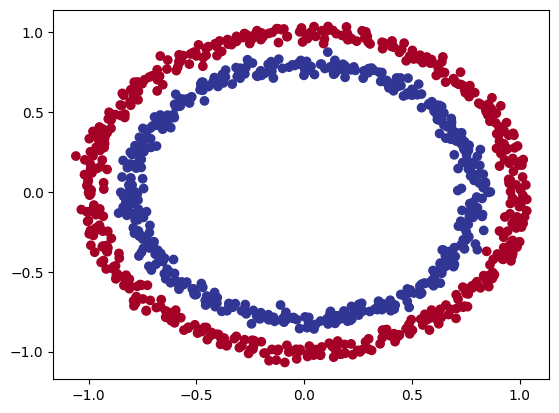

In [5]:
plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [6]:
X.shape, y.shape, X.dtype, y.dtype

((1000, 2), (1000,), dtype('float64'), dtype('int64'))

In [7]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float32).to(device)
y = torch.from_numpy(y).type(torch.float32).to(device)

# View the first five samples
X[:5], y[:5], X.dtype, y.dtype

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]], device='cuda:0'),
 tensor([1., 1., 1., 1., 0.], device='cuda:0'),
 torch.float32,
 torch.float32)

In [9]:
# Split data in train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.8,
                                                    random_state=42)
len(X_train), len(X_test), X_train.dtype

(800, 200, torch.float32)

In [10]:
class CircleModelV0(nn.Module):

  def __init__(self) -> None:
    super(CircleModelV0, self).__init__()

    # Create nn.Linear layers capable of handling the shapes of out data
    self.layer_1 = nn.Linear(in_features=2,
                             out_features=5,
                             device=device) # takes 2 feature upscale tom 5

    self.layer_2 = nn.Linear(in_features=5,
                             out_features=1,
                             device=device) # this is output layer

  # Define forward pass
  def forward(self, X: torch.Tensor) -> torch.Tensor:
    return self.layer_2(self.layer_1(X)) # layer1 -> layer2


model_0 = CircleModelV0()
next(model_0.parameters()).device, model_0

(device(type='cuda', index=0),
 CircleModelV0(
   (layer_1): Linear(in_features=2, out_features=5, bias=True)
   (layer_2): Linear(in_features=5, out_features=1, bias=True)
 ))

In [11]:
# nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5, device=device),
    nn.Linear(in_features=5, out_features=1, device=device))

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6140,  0.1811],
                      [ 0.3720,  0.0991],
                      [ 0.5772,  0.3969],
                      [-0.1002, -0.2157],
                      [ 0.7056, -0.3772]], device='cuda:0')),
             ('0.bias',
              tensor([0.3617, 0.6678, 0.4676, 0.6333, 0.3382], device='cuda:0')),
             ('1.weight',
              tensor([[-0.1803,  0.3355,  0.1645,  0.4302, -0.3121]], device='cuda:0')),
             ('1.bias', tensor([0.3427], device='cuda:0'))])

In [13]:
# loss | optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [14]:
def accuracy_fn(y_true, y_pred):
  """
  Take y_true and y_pred to give accuracy in %.
  """
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_true)) * 100
  return acc

In [15]:
# NOTE:
# loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
#                y_train)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. calculate loss/acc
  loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss which expects logits
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred) # accuracy function

  # 3. Zero grad optimizer
  optimizer.zero_grad()

  # 4. loss backwards
  loss.backward()

  # 5. optimizer step(gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():

    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. calculate loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 10 ==0:
     print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.76215, Accuracy: 50.00% | Test loss: 0.75531, Test acc: 50.00%
Epoch: 10 | Loss: 0.71624, Accuracy: 50.00% | Test loss: 0.71351, Test acc: 50.00%
Epoch: 20 | Loss: 0.70393, Accuracy: 59.13% | Test loss: 0.70207, Test acc: 55.00%
Epoch: 30 | Loss: 0.69987, Accuracy: 52.00% | Test loss: 0.69838, Test acc: 55.50%
Epoch: 40 | Loss: 0.69805, Accuracy: 50.12% | Test loss: 0.69689, Test acc: 55.00%
Epoch: 50 | Loss: 0.69696, Accuracy: 50.12% | Test loss: 0.69615, Test acc: 55.50%
Epoch: 60 | Loss: 0.69619, Accuracy: 50.12% | Test loss: 0.69571, Test acc: 55.50%
Epoch: 70 | Loss: 0.69560, Accuracy: 49.75% | Test loss: 0.69544, Test acc: 54.00%
Epoch: 80 | Loss: 0.69514, Accuracy: 49.62% | Test loss: 0.69525, Test acc: 53.50%
Epoch: 90 | Loss: 0.69477, Accuracy: 49.88% | Test loss: 0.69514, Test acc: 53.50%


In [16]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


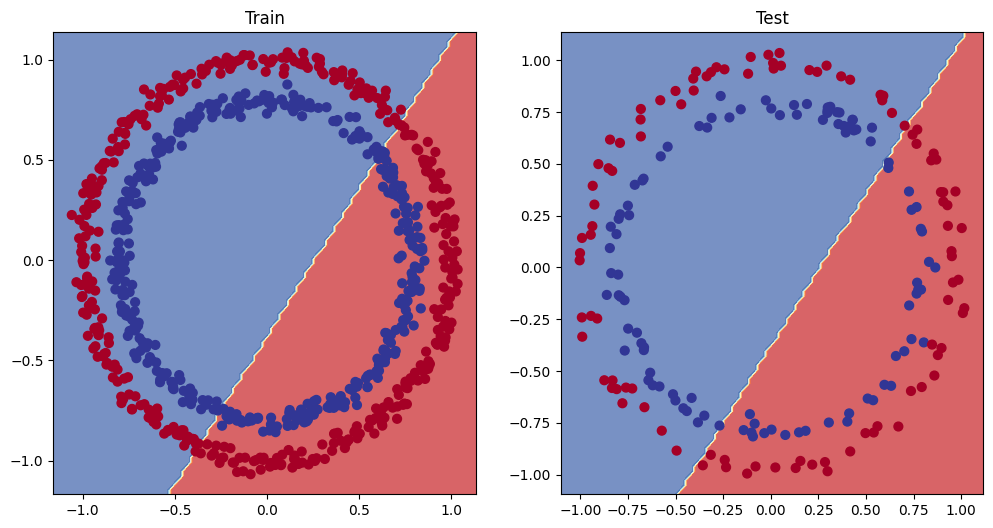

In [17]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0, X_train.cpu(), y_train.cpu())
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test.cpu(), y_test.cpu())
# model only has linear layer so it only tries to split data

## Imporving a model

increasing layer and adding non-linearity

In [18]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super(CircleModelV1, self).__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10, device=device)
    self.layer_2 = nn.Linear(in_features=10, out_features=10, device=device)
    self.layer_3 = nn.Linear(in_features=10, out_features=1, device=device)
    self.relu = nn.ReLU()

  def forward(self, X: torch.Tensor) -> torch.Tensor:
    # z = self.layer_1(X)
    # z = self.layer_2(z)
    # z = self.layer_3(z) # or we can combine all operation
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(X)))))

model_1 = CircleModelV1()
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [19]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [20]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 2000

for epoch in range(epochs):

  model_1.train()

  y_logits= model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()

  with torch.inference_mode():

    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 100 ==0:
     print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69681, Accuracy: 50.00% | Test loss: 0.69689, Test acc: 50.00%
Epoch: 100 | Loss: 0.69237, Accuracy: 49.50% | Test loss: 0.69335, Test acc: 47.50%
Epoch: 200 | Loss: 0.69026, Accuracy: 57.88% | Test loss: 0.69179, Test acc: 55.50%
Epoch: 300 | Loss: 0.68713, Accuracy: 61.00% | Test loss: 0.68936, Test acc: 58.00%
Epoch: 400 | Loss: 0.68298, Accuracy: 61.88% | Test loss: 0.68559, Test acc: 61.00%
Epoch: 500 | Loss: 0.67731, Accuracy: 60.62% | Test loss: 0.68018, Test acc: 63.00%
Epoch: 600 | Loss: 0.66838, Accuracy: 61.25% | Test loss: 0.67178, Test acc: 63.00%
Epoch: 700 | Loss: 0.65625, Accuracy: 63.12% | Test loss: 0.65908, Test acc: 63.50%
Epoch: 800 | Loss: 0.63846, Accuracy: 68.12% | Test loss: 0.64071, Test acc: 68.00%
Epoch: 900 | Loss: 0.60978, Accuracy: 80.62% | Test loss: 0.61339, Test acc: 82.00%
Epoch: 1000 | Loss: 0.56481, Accuracy: 93.38% | Test loss: 0.57206, Test acc: 94.00%
Epoch: 1100 | Loss: 0.49448, Accuracy: 97.38% | Test loss: 0.50639, Test acc:

In [21]:
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()

y_preds[:10], y_test[:10].cpu()

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

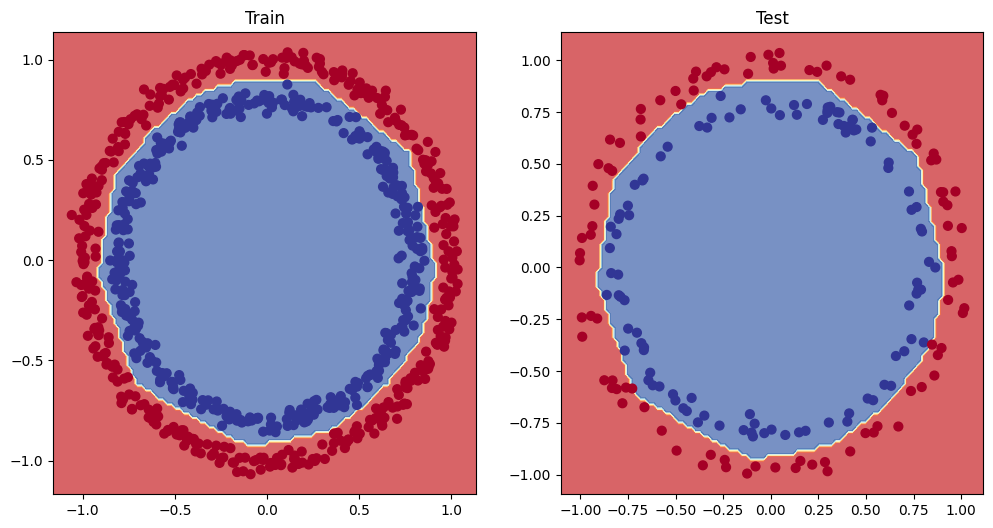

In [22]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1, X_train.cpu(), y_train.cpu())
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1, X_test.cpu(), y_test.cpu())
# model only has linear layer so it only tries to split data

# Multiclass classification

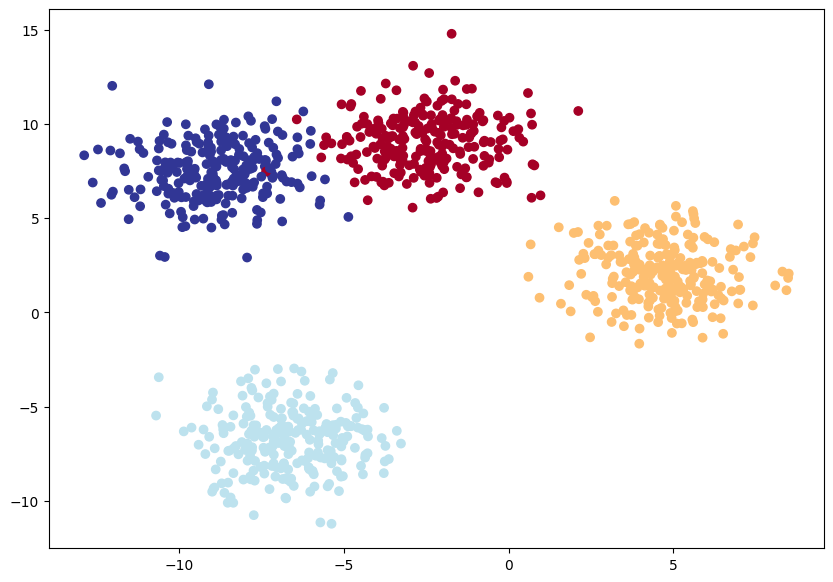

In [33]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

Num_classes = 4
Num_Features = 2
Random_seed = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=Num_Features,
                            centers=Num_classes,
                            cluster_std=1.5, # give cluster a lil shake up
                            random_state=Random_seed)

X_blob = torch.from_numpy(X_blob).type(torch.float).to(device)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor).to(device)

X_train,X_test,y_train,y_test = train_test_split(X_blob,
                                                 y_blob,
                                                 test_size=0.2,
                                                 random_state=Random_seed)

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0].cpu(), X_blob[:, 1].cpu(), c=y_blob.cpu(), cmap = plt.cm.RdYlBu)

In [47]:
class BlobModel(nn.Module):

  def __init__(self, input_features, output_features, hidden_units = 8) -> None:
    '''Initialize Multiclass classification.

    Args:
        Input_features (int) : Number of input features
        Output_features (int) : Number of Output classes
        hidden_units (int) : numebr of hidden neurons default 8
    '''
    super(BlobModel, self).__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units, device=device),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units, device=device),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features, device=device)
    )

  def forward(self, X: torch.Tensor) -> torch.Tensor:
    return self.linear_layer_stack(X)

model_4 = BlobModel(input_features=2,
                    output_features=4)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [48]:
# loss funcrion of multi class
# our outputs gonna be logits and we need to convert them in to prediction prob, and then
# prediction labels

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr = 0.1)

In [49]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

for epoch in range(epochs):

  model_4.train()

  y_logits= model_4(X_train).squeeze() # we get 4 logits as 4 class
  y_pred = torch.sigmoid(y_logits).argmax(dim=1) # logits -> prediction and argmax to find index of max_pred

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_4.eval()

  with torch.inference_mode():

    test_logits = model_4(X_test).squeeze()
    test_pred = torch.sigmoid(test_logits).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 10 ==0:
     print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.73926, Accuracy: 48.50% | Test loss: 0.61958, Test acc: 65.50%
Epoch: 10 | Loss: 0.16356, Accuracy: 99.12% | Test loss: 0.14881, Test acc: 99.00%
Epoch: 20 | Loss: 0.08904, Accuracy: 99.25% | Test loss: 0.08131, Test acc: 99.50%
Epoch: 30 | Loss: 0.06368, Accuracy: 99.12% | Test loss: 0.05644, Test acc: 99.50%
Epoch: 40 | Loss: 0.05155, Accuracy: 99.25% | Test loss: 0.04412, Test acc: 99.50%
Epoch: 50 | Loss: 0.04460, Accuracy: 99.25% | Test loss: 0.03692, Test acc: 99.50%
Epoch: 60 | Loss: 0.04017, Accuracy: 99.25% | Test loss: 0.03223, Test acc: 99.50%
Epoch: 70 | Loss: 0.03712, Accuracy: 99.25% | Test loss: 0.02897, Test acc: 99.50%
Epoch: 80 | Loss: 0.03492, Accuracy: 99.25% | Test loss: 0.02656, Test acc: 99.50%
Epoch: 90 | Loss: 0.03326, Accuracy: 99.25% | Test loss: 0.02473, Test acc: 99.50%


In [50]:
model_4.eval()
with torch.inference_mode():
  y_preds = torch.sigmoid(model_4(X_test).squeeze()).argmax(dim=1)

torch.eq(y_preds,y_test).sum().item()/len(y_test) * 100

99.5

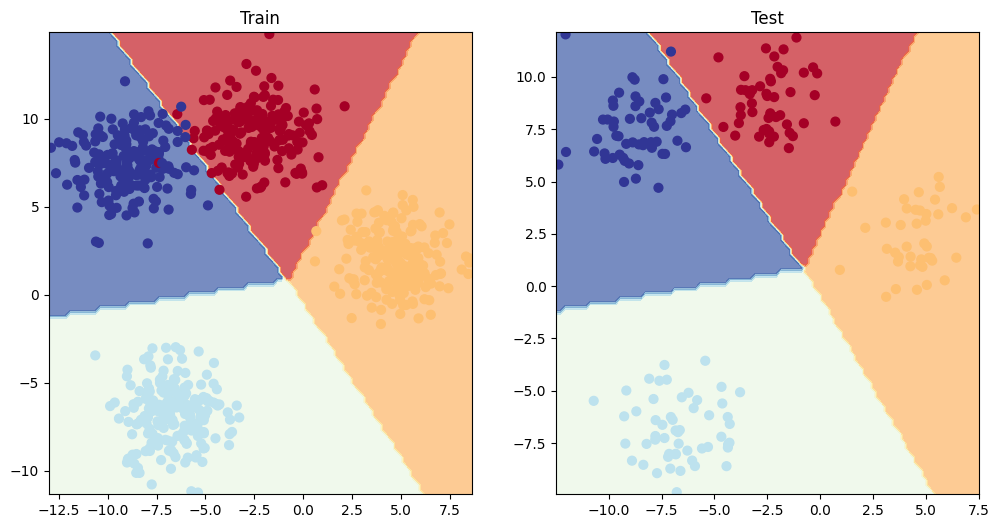

In [51]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_4, X_train.cpu(), y_train.cpu())
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_4, X_test.cpu(), y_test.cpu())

In [53]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_test)

tensor(0.9950, device='cuda:0')